In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def init_H_as_power_of_2(n):
    H = np.array([2 ** -i for i in range(n)])
    return H

$Tags$
* upwind_1
* upwind_2
* central_4
* central_6
* eulermod_4
* eulermod_6
* heun_2
* heun_4
* heun_6
* rungekutta_7

In [3]:
def right_function_2(U, h):
    return -(U[2:] - U[:-2]) / 2. / h
def right_function_4(U, h):
    return -(U[:-4] - U[4:] + 8. * (U[3:-1] - U[1:-3])) / 12. / h
def right_function_6(U, h):
    return -(U[6:] - U[:-6] + 9. * (U[1:-5] - U[5:-1]) + 45. * (U[4:-2] - U[2:-4])) / 60. / h

In [4]:
def errs_for_different_h(H, c, L, r, tag, T = 100., with_plots = True):
    N_errs = H.size
    errs = np.zeros(N_errs)
    if with_plots:
        fig, axs = plt.subplots(N_errs, 1, figsize = (10, 8))
    for i, h in zip(range(N_errs), H):
        Nx = int(L / h)
        dt = r * h
        if tag == 'upwind_1' or tag == 'upwind_2' or tag == 'rungekutta_7':
            dt = r * h
        elif tag == 'central_4' or tag == 'central_6' or tag == 'heun_2' or tag == 'heun_4' or tag == 'heun_6':
            dt = r * h ** 2
        elif tag == 'eulermod_4':
            dt = r ** (1. / 3.) * h ** (4. / 3.)
        elif tag == 'eulermod_6':
            dt = r * h ** (4. / 3.) # ??
        else:
            print('Unknown tag!')
        Nt = int(T / dt) + 1
        x = np.linspace(0, L, Nx + 1)

        def init(x0, x1):
            U = np.zeros(Nx)
            U[x0:x1] = np.abs(np.sin((x[x0:x1] - x[x0]) * np.pi / (x[x1] - x[x0])) ** 6)
            return U
        
        def solve(U, Nt): 
            if tag == 'upwind_1':
                for n in range(Nt - 1):
                    U[1:] = U[1:] - c * dt / h * (U[1:] - U[:-1])
            elif tag == 'upwind_2':
                for n in range(Nt - 1):
                    U[2:] = U[2:] - c * dt / h * (U[0:-2] - 4 * U[1:-1] + 3 * U[2:]) / 2
            elif tag == 'central_4':
                for n in range(Nt - 1):
                    U[2:-2] = U[2:-2] - c * dt / h * (U[:-4] - U[4:] + 8 * (U[3:-1] - U[1:-3])) / 12
            elif tag == 'central_6':
                for n in range(Nt - 1):
                    U[3:-3] = U[3:-3] - c * dt / h * (U[6:] - U[:-6] + 9 * (U[1:-5] - U[5:-1]) + 45 * (U[4:-2] - U[2:-4])) / 60
            elif tag == 'eulermod_4':
                U_star = np.zeros_like(U)
                for n in range(Nt - 1):
                    U_star[2:-2] = U[2:-2] + 0.5 * c * dt * right_function_4(U, h)
                    U[2:-2] = U[2:-2] + c * dt * right_function_4(U_star, h)
            elif tag == 'eulermod_6':
                U_star = np.zeros_like(U)
                for n in range(Nt - 1):
                    U_star[3:-3] = U[3:-3] + 0.5 * c * dt * right_function_6(U, h)
                    U[3:-3] = U[3:-3] + c * dt * right_function_6(U_star, h)
            elif tag == 'heun_2':
                U_star = np.zeros_like(U)
                U_star2 = np.zeros_like(U)
                for n in range(Nt - 1):
                    U_star[1:-1] = U[1:-1] + c * dt * right_function_2(U, h) / 3.
                    U_star2[1:-1] = U[1:-1] + 2. * c * dt * right_function_2(U_star, h) / 3.
                    U[1:-1] = 0.25 * U[1:-1] + 0.75 * U_star[1:-1] + 0.75 * c * dt * right_function_2(U_star2, h)
            elif tag == 'heun_4':
                U_star = np.zeros_like(U)
                U_star2 = np.zeros_like(U)
                for n in range(Nt - 1):
                    U_star[2:-2] = U[2:-2] + c * dt * right_function_4(U, h) / 3.
                    U_star2[2:-2] = U[2:-2] + 2. * c * dt * right_function_4(U_star, h) / 3.
                    U[2:-2] = 0.25 * U[2:-2] + 0.75 * U_star[2:-2] + 0.75 * c * dt * right_function_4(U_star2, h)
            elif tag == 'heun_6':
                U_star = np.zeros_like(U)
                U_star2 = np.zeros_like(U)
                for n in range(Nt - 1):
                    U_star[3:-3] = U[3:-3] + c * dt * right_function_6(U, h) / 3.
                    U_star2[3:-3] = U[3:-3] + 2. * c * dt * right_function_6(U_star, h) / 3.
                    U[3:-3] = 0.25 * U[3:-3] + 0.75 * U_star[3:-3] + 0.75 * c * dt * right_function_6(U_star2, h)
            elif tag == 'rungekutta_7':
                # with 6 order for x
                k1 = np.zeros_like(U)
                k2 = np.zeros_like(U)
                k3 = np.zeros_like(U)
                k4 = np.zeros_like(U)
                k5 = np.zeros_like(U)
                k6 = np.zeros_like(U)
                k7 = np.zeros_like(U)
                k8 = np.zeros_like(U)
                k9 = np.zeros_like(U)
                for n in range(Nt - 1):
                    # dt!!!
                    k1[3:-3] = right_function_6(U, h)
                    k2[3:-3] = right_function_6(U + c * dt * k1  / 6.0, h)
                    k3[3:-3] = right_function_6(U + c * dt * k2  / 3.0, h)
                    k4[3:-3] = right_function_6(U + c * dt * k1  / 8.0 + c * dt * k3 * 3.0  / 8.0, h)
                    k5[3:-3] = right_function_6(U + c * dt * k1 * 148.0  / 1331.0 + c * dt * k3 * 150.0  / 1331.0 - c * dt * k4 * 56.0  / 1331.0, h)
                    k6[3:-3] = right_function_6(U - c * dt * k1 * 404.0  / 243.0 - c * dt * k3 * 170.0  / 27.0 + c * dt * k4 * 4024.0  / 1701.0 + c * dt * k5 * 10648.0  / 1701.0, h)
                    k7[3:-3] = right_function_6(U + c * dt * k1 * 2466.0  / 2401.0 + c * dt * k3 * 1242.0  / 343.0 - c * dt * k4 * 19176.0  / 16807.0 - c * dt * k5 * 51909.0  / 16807.0 + c * dt * k6 * 1053.0  / 2401.0, h)
                    k8[3:-3] = right_function_6(U + c * dt * k1 * 5.0  / 154.0 + c * dt * k4 * 96.0  / 539.0 - c * dt * k5 * 1815.0  / 20384.0 - c * dt * k6 * 405.0  / 2464.0 + c * dt * k7 * 49.0  / 1144.0, h)
                    k9[3:-3] = right_function_6(U - c * dt * k1 * 113.0  / 32.0 - c * dt * k3 * 195.0  / 22.0 + c * dt * k4 * 32.0  / 7.0 + c * dt * k5 * 29403.0  / 3584.0 - c * dt * k6 * 729.0  / 512.0 + c * dt * k7 * 1029.0  / 1408.0 + c * dt * k8 * 21.0  / 16.0, h)
                    U = U + c * dt * k4 * 32.0  / 105.0 + c * dt * k5 * 1771561.0  / 6289920.0 + c * dt * k6 * 243.0  / 2560.0 + c * dt * k7 * 16807.0  / 74880.0 + c * dt * k8 * 77.0  / 1440.0 + c * dt * k9 * 11.0  / 270.0
            else:
                print('Unknown tag!')
            return U
        
        x0 = int(Nx / 2) - int(20 / h)
        x1 = x0 + int(40 / h)
        U = init(x0, x1)
        U_n = solve(U, Nt)
        cTh = int(c * T / h)
        U_ex = init(x0 + cTh, x1 + cTh)
        errs[i] = np.sqrt(np.sum((U_n[x0 + cTh: x1 + cTh] - U_ex[x0 + cTh: x1 + cTh]) ** 2 * h))
        if with_plots:
            axs[i].plot(x[x0 + cTh - 100: x1 + cTh + 100], U_n[x0 + cTh - 100: x1 + cTh + 100], label = 'h = ' + str(h));
            axs[i].plot(x[x0 + cTh - 100: x1 + cTh + 100], U_ex[x0 + cTh - 100: x1 + cTh + 100], '--', label = 'exact');
            axs[i].set_xlabel('x')
            axs[i].set_ylabel('U(' + tag + ')')
            axs[i].grid()
            axs[i].legend()
    return errs

In [5]:
def least_squares_linear(x, y):
    # y = a * x + b
    n = x.size
    sx2 = np.sum(x ** 2)
    sx = np.sum(x)
    sy = np.sum(y)
    sxy = np.sum(x * y)
    d = n * sx2 - sx * sx
    da = n * sxy - sx * sy
    db = sx2 * sy - sx * sxy
    return da / d, db / d

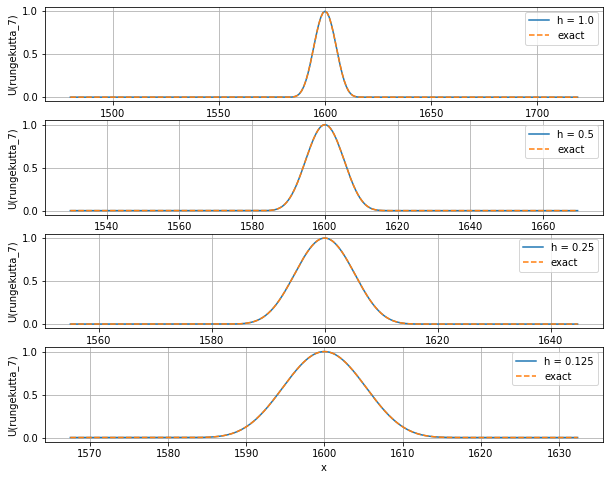

In [6]:
c = 1.
L = 3000.
H = init_H_as_power_of_2(4)
#errs_heun_2 = errs_for_different_h(H, c, L, r = 0.5, tag = 'heun_2', with_plots = False)
#errs_heun_4 = errs_for_different_h(H, c, L, r = 0.5, tag = 'heun_4', with_plots = False)
#errs_heun_6 = errs_for_different_h(H, c, L, r = 0.5, tag = 'heun_6', with_plots = False)
errs_rungekutta_7 = errs_for_different_h(H, c, L, r = 0.1, tag = 'rungekutta_7', with_plots = True)

5.96376043169253


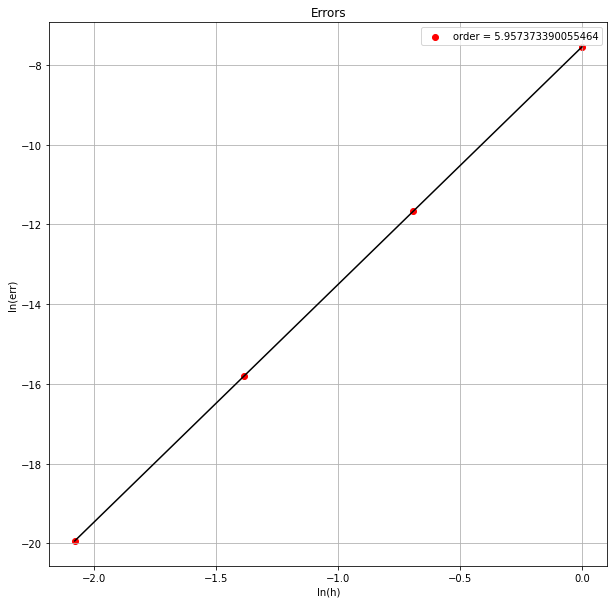

In [7]:
#errs = [errs_heun_2, errs_heun_4, errs_heun_6]
errs = [errs_rungekutta_7]
colors = ['red', 'green', 'blue']
plt.figure(figsize = (10, 10))
plt.grid()
plt.title('Errors')
plt.xlabel('ln(h)')
plt.ylabel('ln(err)')
for i, err in enumerate(errs):
    a, b = least_squares_linear(np.log(H), np.log(err))
    plt.scatter(np.log(H), np.log(err), color = colors[i], label = 'order = ' + str(a));
    plt.plot(np.log(H), a * np.log(H) + b, color = 'black')
    plt.legend()
    print(np.log(err[-2] / err[-1]) / np.log(2.))